In [95]:
import geopandas as gp
costanera_buildings = gp.read_file('../shapefiles/buildings/Buildings_Costanera_activity.shp')

,Destino,Activity,geometry
0,HABITACIONAL,1000,"POLYGON ((673120.714 5921483.603, 673109.209 5..."
1,HABITACIONAL,1000,"POLYGON ((673051.081 5921458.906, 673045.231 5..."
2,HABITACIONAL,1000,"POLYGON ((673084.387 5921474.259, 673087.412 5..."
3,HABITACIONAL,1000,"POLYGON ((673155.770 5921468.684, 673157.641 5..."
4,HABITACIONAL,1000,"POLYGON ((673126.724 5921471.405, 673116.800 5..."


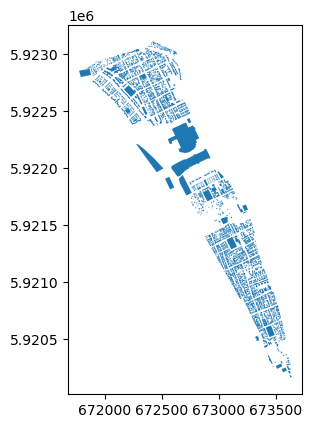

In [96]:
costanera_buildings.plot()
costanera_buildings.head()

In [97]:
costanera_buildings['Usage'] = costanera_buildings.apply(lambda row: 'R' if row['Activity'] < 2000 else 'O', axis=1)    
costanera_buildings.head()

,Destino,Activity,geometry,Usage
0,HABITACIONAL,1000,"POLYGON ((673120.714 5921483.603, 673109.209 5...",R
1,HABITACIONAL,1000,"POLYGON ((673051.081 5921458.906, 673045.231 5...",R
2,HABITACIONAL,1000,"POLYGON ((673084.387 5921474.259, 673087.412 5...",R
3,HABITACIONAL,1000,"POLYGON ((673155.770 5921468.684, 673157.641 5...",R
4,HABITACIONAL,1000,"POLYGON ((673126.724 5921471.405, 673116.800 5...",R


In [98]:
from shapely.geometry import shape
costanera_buildings['Area'] = costanera_buildings.apply(lambda row: shape(row['geometry']).area, axis=1)  
costanera_buildings.head()  

,Destino,Activity,geometry,Usage,Area
0,HABITACIONAL,1000,"POLYGON ((673120.714 5921483.603, 673109.209 5...",R,90.146762
1,HABITACIONAL,1000,"POLYGON ((673051.081 5921458.906, 673045.231 5...",R,195.006940
2,HABITACIONAL,1000,"POLYGON ((673084.387 5921474.259, 673087.412 5...",R,101.624005
3,HABITACIONAL,1000,"POLYGON ((673155.770 5921468.684, 673157.641 5...",R,250.890106
4,HABITACIONAL,1000,"POLYGON ((673126.724 5921471.405, 673116.800 5...",R,149.251804


In [99]:
from sklearn.cluster import KMeans

area_array = costanera_buildings.Area.to_numpy().reshape(-1,1)

general_kmeans = KMeans(n_clusters=3, random_state=43, n_init='auto')
general_kmeans.fit(area_array)

residential_df = costanera_buildings[costanera_buildings['Usage'] == 'R']
residential_area_array = residential_df.Area.to_numpy().reshape(-1,1)
residential_kmeans = KMeans(n_clusters=3, random_state=43, n_init='auto')
residential_kmeans.fit(residential_area_array)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

I

KMeans(n_clusters=3, n_init='auto', random_state=43)

In [100]:
print(general_kmeans.cluster_centers_)


[[  108.9236652 ]
 [36091.57926098]
 [ 6401.73233737]]


In [101]:
print(residential_kmeans.cluster_centers_)

[[ 65.68167553]
 [217.56306055]
 [673.22684631]]


In [102]:
# Looking at the centroids:
# Cluster 0 -> Small
# Cluster 1 -> Large
# Cluster 2 -> Medium
# For residences:
# Cluster 0 -> Small
# Cluster 1 -> Medium
# Cluster 2 -> Large

import numpy as np

def get_scale(row):
    if row['Usage'] == 'O':
        cluster = general_kmeans.predict(np.array(row['Area']).reshape(-1, 1))
        if cluster == 0:
            return 'S'
        elif cluster == 2:
            return 'M'
        else:
            return 'L'
    elif row['Usage'] == 'R':    
        cluster = residential_kmeans.predict(np.array(row['Area']).reshape(-1, 1))
        if cluster == 0:
            return 'S'
        elif cluster == 1:
            return 'M'
        else:
            return 'L'

costanera_buildings['Scale'] = costanera_buildings.apply(lambda row: get_scale(row), axis=1)  
costanera_buildings.head()

,Destino,Activity,geometry,Usage,Area,Scale
0,HABITACIONAL,1000,"POLYGON ((673120.714 5921483.603, 673109.209 5...",R,90.146762,S
1,HABITACIONAL,1000,"POLYGON ((673051.081 5921458.906, 673045.231 5...",R,195.006940,M
2,HABITACIONAL,1000,"POLYGON ((673084.387 5921474.259, 673087.412 5...",R,101.624005,S
3,HABITACIONAL,1000,"POLYGON ((673155.770 5921468.684, 673157.641 5...",R,250.890106,M
4,HABITACIONAL,1000,"POLYGON ((673126.724 5921471.405, 673116.800 5...",R,149.251804,M


In [103]:
import yaml

transform_object = yaml.safe_load(open('./helper/LBCS_activity_to_category.yml'))

def building_type(row):
    activity_code = row['Activity']
    return transform_object[str(activity_code)]

costanera_buildings['Category'] = costanera_buildings.apply(lambda row: building_type(row), axis=1)  
costanera_buildings.head()

,Destino,Activity,geometry,Usage,Area,Scale,Category
0,HABITACIONAL,1000,"POLYGON ((673120.714 5921483.603, 673109.209 5...",R,90.146762,S,R
1,HABITACIONAL,1000,"POLYGON ((673051.081 5921458.906, 673045.231 5...",R,195.006940,M,R
2,HABITACIONAL,1000,"POLYGON ((673084.387 5921474.259, 673087.412 5...",R,101.624005,S,R
3,HABITACIONAL,1000,"POLYGON ((673155.770 5921468.684, 673157.641 5...",R,250.890106,M,R
4,HABITACIONAL,1000,"POLYGON ((673126.724 5921471.405, 673116.800 5...",R,149.251804,M,R


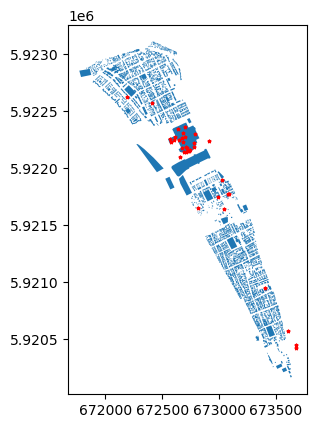

,osm_id,code,fclass,name,NAICS_CODE,geometry
0,1280964414,2501,supermarket,Jumbo,45,POINT Z (673676.687 5920414.037 0.000)
1,1875411202,2301,restaurant,Chuck E. Cheese's,72,POINT Z (672658.501 5922091.158 0.000)
2,1875411206,2501,supermarket,Tottus,45,POINT Z (672700.020 5922359.831 0.000)
3,2182738189,2302,fast_food,Fritz,72,POINT Z (672677.483 5922172.798 0.000)
4,2182738191,2301,restaurant,Pizza Hut,72,POINT Z (672721.777 5922176.007 0.000)


In [104]:
import matplotlib.pyplot as plt

costanera_amenities = gp.read_file('../shapefiles/amenities/Services.shp')

costanera_amenities = costanera_amenities.to_crs(costanera_buildings.crs)

ax = costanera_buildings.plot()
costanera_amenities.plot(ax=ax, marker='*', color='red', markersize=5)
plt.show()

costanera_amenities.head()

In [105]:
transform_fclass_object = yaml.safe_load(open('./helper/amenity_fclass_to_category.yml'))

for i, amenity in costanera_amenities.iterrows():
    array_result = costanera_buildings.contains(amenity.geometry)
    try:
        index = array_result.tolist().index(True)
        if index > -1:
            current_category = costanera_buildings.iloc[index]['Category']
            new_category = transform_fclass_object[str(amenity.fclass)]
            costanera_buildings.at[index,'Category'] = current_category if new_category in current_category else current_category + ',' + new_category
    except:
        continue      

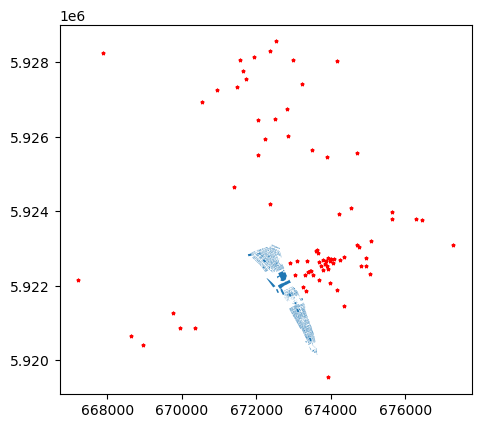

,Id,Nombre,Tipo,SUBTIPO,Categoria,geometry
0,1,UDD,Universidad,Facultad,Educación,POINT (673929.742 5919544.295)
1,2,Virginio Gómez,IPT,NaN,Educación,POINT (673332.398 5921866.945)
2,3,AIEP,IPT,NaN,Educación,POINT (673255.682 5921982.817)
3,4,UCSC,Universidad,Facultad de Derecho,Educación,POINT (673680.815 5922155.428)
4,5,Universidad La República,Universidad,NaN,Educación,POINT (673526.585 5922307.261)


In [106]:
import matplotlib.pyplot as plt

concepcion_metro_amenities = gp.read_file('../shapefiles/amenities-metro/Amenities_Concepcion_Metropolitano.shp')

crs = costanera_buildings.crs
concepcion_metro_amenities = concepcion_metro_amenities.to_crs(costanera_buildings.crs)

ax = costanera_buildings.plot()
concepcion_metro_amenities.plot(ax=ax, marker='*', color='red', markersize=5)
plt.show()

concepcion_metro_amenities.head()

In [107]:
from shapely.geometry import Polygon
import pyproj

transform_tipo_object = yaml.safe_load(open('./helper/amenity_tipo_metro_to_category.yml'))

concepcion_metro_amenities['Tipo'].fillna('O', inplace=True)

for i, amenity in concepcion_metro_amenities.iterrows():
    diff = 80
    polygon = Polygon([(amenity.geometry.x, amenity.geometry.y),(amenity.geometry.x, amenity.geometry.y + diff),(amenity.geometry.x + diff, amenity.geometry.y + diff), (amenity.geometry.x + diff, amenity.geometry.y)])
    
    amenity_category = transform_tipo_object[str(amenity.Tipo)]
    amenity_category = 'O' if amenity_category == None else amenity_category
    new_building = {"geometry": polygon, "Scale": "M", "Category":amenity_category}
    costanera_buildings = costanera_buildings.append(new_building, ignore_index=True)

/var/folders/r5/06grv18s3j5391c28dt3l91m0000gn/T/ipykernel_1728/1559057888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  costanera_buildings = costanera_buildings.append(new_building, ignore_index=True)
/var/folders/r5/06grv18s3j5391c28dt3l91m0000gn/T/ipykernel_1728/1559057888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  costanera_buildings = costanera_buildings.append(new_building, ignore_index=True)
/var/folders/r5/06grv18s3j5391c28dt3l91m0000gn/T/ipykernel_1728/1559057888.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  costanera_buildings = costanera_buildings.append(new_building, ignore_index=True)
/var/folders/r5/06grv18s3j5391c28dt3l91m0000gn/T/ipykernel_1728/1559057888.py:14: FutureWarning: The fr

In [110]:
costanera_buildings = costanera_buildings.to_crs(concepcion_metro_amenities.crs)

costanera_buildings.plot()
costanera_buildings.head()

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

In [109]:
costanera_buildings.to_file('../includes/city/costanera/Buildings.shp')  
